# Plot climatology of sea ice volume tendency
Questions:
  1) How does OM3 compare with OM2?
  2) Does the sum of freeze + melt match the `dvidtt` diagnostic?

In [1]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/tm70/as2285/access-om3-paper-figs/


In [2]:
import xarray as xr
import numpy as np
import cf_xarray
from datetime import timedelta
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

import pandas as pd
pd.set_option('display.max_rows', 500)

In [3]:
IAF = esm_file.find('iaf') > 0
IAF

True

In [4]:
if IAF:
    om2_exp = '025deg_jra55_iaf_omip2_cycle6'
else:
    om2_exp = '025deg_jra55_ryf9091_gadi'

In [5]:
client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

### Open the intake-esm datastore

In [6]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

### What ocean variables are available at monthly frequency?

In [7]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [8]:
datastore_filtered = datastore.search(realm="seaIce", frequency="1mon")
datastore_filtered_grid = datastore.search(realm="seaIce", frequency="fx")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
ANGLE,angle grid makes with latitude line on U grid,,,radians
ANGLET,angle grid makes with latitude line on T grid,,,radians
NCAT,category maximum thickness,,,m
Tair_m,air temperature,,time: mean,C
Tsfc_m,snow/ice surface temperature,,time: mean,C
VGRDa,vertical snow-ice-bio levels,,,1
VGRDb,vertical ice-bio levels,,,1
VGRDi,vertical ice levels,,,1
VGRDs,vertical snow levels,,,1


In [9]:
available_variables(datastore_filtered_grid)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
ANGLE,angle grid makes with latitude line on U grid,,,radians
ANGLET,angle grid makes with latitude line on T grid,,,radians
ELAT,E grid center latitude,,,degrees_north
ELON,E grid center longitude,,,degrees_east
HTE,T cell width on East side,,,m
HTN,T cell width on North side,,,m
NCAT,category maximum thickness,,,m
NFSD,category floe size (center),,,m
NLAT,N grid center latitude,,,degrees_north


### Load ACCESS-OM3 sea ice mass budget diagnostics using the ESM datastore

In [10]:
variables = ["aice_m", "congel_m", "frazil_m", "snoice_m", "meltt_m", "meltb_m", "meltl_m", "evap_ai_m", "dvidtt_m"]
ds = datastore.search(variable=variables, frequency="1mon").to_dask(
    xarray_open_kwargs = dict(chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
                              decode_timedelta=True,),
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Pick the last 10 years

In [11]:
if IAF:
    t_slice = slice('2009','2018') #manually pick some years in both om2 & 3 experiments
else:
    years = np.unique(ds.time.dt.year)[-10:]
    t_slice = slice(str(years[0]),str(years[-1]))
    t_slice

In [12]:
ds = ds.sel(time=t_slice)
ds

<xarray.Dataset> Size: 14GB
Dimensions:    (time: 120, nj: 1152, ni: 1440)
Coordinates:
  * time       (time) datetime64[ns] 960B 2009-01-16T12:00:00 ... 2018-12-16T...
Dimensions without coordinates: nj, ni
Data variables:
    frazil_m   (time, nj, ni) float64 2GB dask.array<chunksize=(1, 384, 720), meta=np.ndarray>
    dvidtt_m   (time, nj, ni) float64 2GB dask.array<chunksize=(1, 384, 720), meta=np.ndarray>
    meltl_m    (time, nj, ni) float64 2GB dask.array<chunksize=(1, 384, 720), meta=np.ndarray>
    snoice_m   (time, nj, ni) float64 2GB dask.array<chunksize=(1, 384, 720), meta=np.ndarray>
    congel_m   (time, nj, ni) float64 2GB dask.array<chunksize=(1, 384, 720), meta=np.ndarray>
    evap_ai_m  (time, nj, ni) float64 2GB dask.array<chunksize=(1, 384, 720), meta=np.ndarray>
    meltb_m    (time, nj, ni) float64 2GB dask.array<chunksize=(1, 384, 720), meta=np.ndarray>
    aice_m     (time, nj, ni) float64 2GB dask.array<chunksize=(1, 384, 720), meta=np.ndarray>
    meltt_m    (time, nj, ni) float64 2GB dask.array<chunksize=(1, 384, 720), meta=np.ndarray>
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    time_axis_position:                       middle
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,time: mean,time: mean,,,,,ti...
    intake_esm_attrs:variable_units:          radians,radians,m,C,C,1,1,1,1,1...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   seaIce.1mon.nbnd:2.nc:5.ni:1440...

Calculate the monthly climatology for these last 10 years.

In [13]:
ds_clim = ds.groupby('time.month').mean('time').compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Load grid cell area from cice variable

In [14]:
tarea = datastore.search(variable="tarea", frequency="fx", realm="seaIce").to_dask().compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


Integrate terms for both poles. The terms are currently in cm/day, so convert to m/day 

In [15]:
antarctic_seaice = (ds_clim * tarea.tarea / 100).sel(nj=slice(0,int(len(ds.nj)/2))).sum(['nj','ni'])
arctic_seaice = (ds_clim * tarea.tarea / 100).sel(nj=slice(int(len(ds.nj)/2), None)).sum(['nj','ni'])

### Load ACCESS-OM2 sea ice mass budget diagnostics using the intake catalog

In [16]:
catalog = intake.cat.access_nri

In [17]:
var = catalog[om2_exp].search(variable=variables,frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
ds_om2=var.to_dask(xarray_open_kwargs=dict(chunks={"time": -1},
                                                   decode_timedelta=True,
                                                   use_cftime=True), 
                           xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override", data_vars="minimal", coords="minimal",),                          
)

# shift time to correct for OM2 calendar strangeness
def shift_time(ds):
    ds["time"] = ds.time.to_pandas() - timedelta(minutes=1)
    return ds

ds_om2 = shift_time(ds_om2)

# select out the same 10 years as for OM3
ds_om2 = ds_om2.sel(time=t_slice)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [18]:
print(ds_om2.time.min().values, ds_om2.time.max().values)

2009-01-31 23:59:00 2018-12-31 23:59:00


Calculate the monthly climatology for these last 10 years.

In [19]:
ds_clim_om2 = ds_om2.groupby('time.month').mean('time').compute()

Load grid cell area variable

In [20]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='tarea', frequency="1mon", start_date='1940-01-01.*')
ds_om2_tarea = var.to_dask()

Integrate terms for both poles. The terms are currently in cm/day. 

In [21]:
antarctic_seaice_om2 = (ds_clim_om2 * ds_om2_tarea.tarea / 100).sel(nj=slice(0,int(len(ds_om2.nj)/2))).sum(['nj','ni']).compute()
arctic_seaice_om2 = (ds_clim_om2 * ds_om2_tarea.tarea / 100).sel(nj=slice(int(len(ds_om2.nj)/2), None)).sum(['nj','ni']).compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 640.76 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 640.76 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


### Plot Antarctic sea ice climatology

In [22]:
def figure(region):
    plt.rcParams['font.size'] = 12
    fig, axes = plt.subplots(ncols=3, figsize=(21,4), sharex=True)
    plt.subplots_adjust(wspace=0.12)

    axes[0].text(0.0, 1.03, 'a) ACCESS-OM3', fontsize=12, fontweight='bold', transform=axes[0].transAxes)
    axes[1].text(0.0, 1.03, 'b) ACCESS-OM2', fontsize=12, fontweight='bold', transform=axes[1].transAxes)
    axes[2].text(0.0, 1.03, 'c) ACCESS-OM3 - ACCESS-OM2', fontsize=12, fontweight='bold', transform=axes[2].transAxes)

    for i, ax in enumerate(axes):
        ax.text(0.99, 1.03, f'{region}', ha='right', fontsize=12, transform=ax.transAxes)
        ax.plot(np.arange(1,13,1), np.full(12,0), lw=0.5, c='k')
        ax.set_xlim([1,12])
        ax.set_xticks(np.arange(1,13,1))
        ax.set_xlabel('Month')
    
    axes[0].set_ylabel('Sea ice volume tendency\n(x1000 km$^3$ day$^{-1}$)')
        
    return fig, axes

Sum of freeze and melt versus `dvidtt` diagnostic

**Note:** Not using `evap_ai_m` because this includes evaporation from snow. There is no diagnostic (currently) for `evap_ice`.

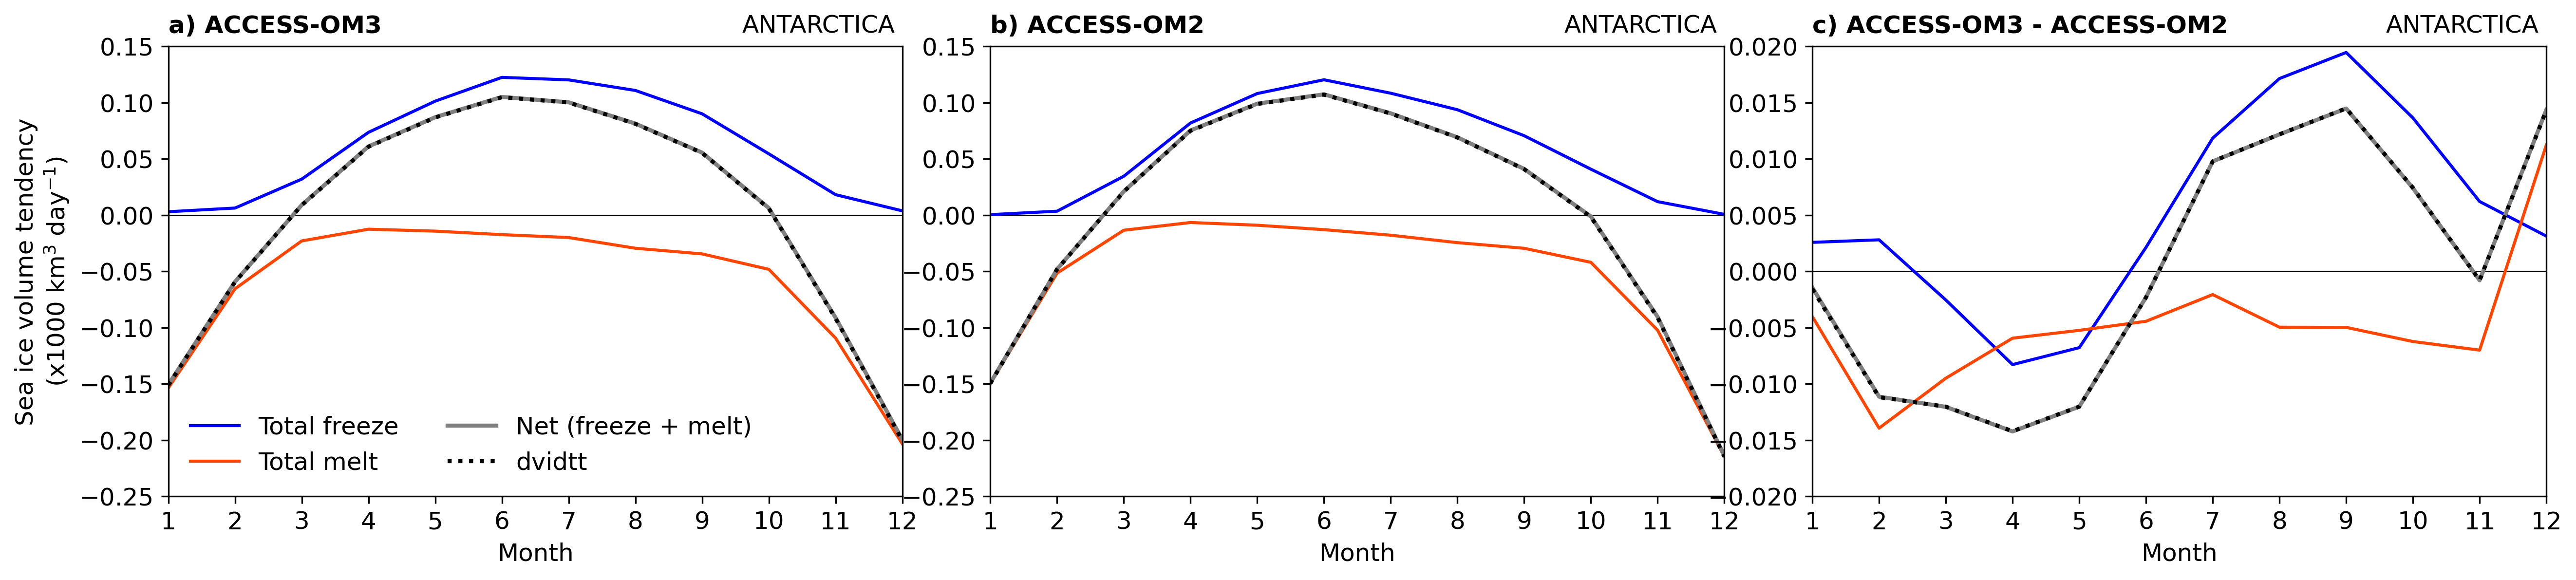

In [23]:
region = 'ANTARCTICA'
fig, axes = figure(region)

x = np.arange(1, 13, 1)

### OM3 ###
freeze =  antarctic_seaice['frazil_m'] + antarctic_seaice['congel_m'] + antarctic_seaice['snoice_m']
melt = antarctic_seaice['meltb_m'] + antarctic_seaice['meltt_m'] + antarctic_seaice['meltl_m']
axes[0].plot(x, freeze/1e12, c='blue', label='Total freeze')
axes[0].plot(x, -melt/1e12, c='orangered', label='Total melt')
axes[0].plot(x, (freeze - melt)/1e12, c='grey', lw=2, label='Net (freeze + melt)')
axes[0].plot(x, antarctic_seaice['dvidtt_m']/1e12, c='k', ls=':', lw=2, label='dvidtt')

axes[0].legend(frameon=False, ncols=2, fontsize=12)

### OM2 ###
freeze_om2 =  antarctic_seaice_om2['frazil_m'] + antarctic_seaice_om2['congel_m'] + antarctic_seaice_om2['snoice_m']
melt_om2 = antarctic_seaice_om2['meltb_m'] + antarctic_seaice_om2['meltt_m'] + antarctic_seaice_om2['meltl_m']
axes[1].plot(x, freeze_om2/1e12, c='blue', label='Total freeze')
axes[1].plot(x, -melt_om2/1e12, c='orangered', label='Total melt')
# axes[0].plot(x, -melt_om2/1e12, c='firebrick', label='Total melt')
axes[1].plot(x, (freeze_om2 - melt_om2)/1e12, c='grey', lw=2, label='Net (freeze + melt)')
axes[1].plot(x, antarctic_seaice_om2['dvidtt_m']/1e12, c='k', ls=':', lw=2, label='dvidtt')

### Difference (OM3 - OM2) ###
axes[2].plot(x, (freeze - freeze_om2)/1e12, c='blue', label='Total freeze')
axes[2].plot(x, (-melt - -melt_om2)/1e12, c='orangered', label='Total melt')
axes[2].plot(x, ((freeze - melt) - (freeze_om2 - melt_om2))/1e12, c='grey', lw=2, label='Net (freeze + melt)')
axes[2].plot(x, (antarctic_seaice['dvidtt_m'] - antarctic_seaice_om2['dvidtt_m'])/1e12, c='k', ls=':', lw=2, label='dvidtt')

axes[0].set_ylim([-0.25, 0.15])
axes[1].set_ylim([-0.25, 0.15])
axes[2].set_ylim([-0.02, 0.02])

figfile = plotfolder + f'seaice_vol_budget_{region}.jpg'
plt.savefig(figfile, dpi=300, bbox_inches='tight') 

plt.show()

### Plot Arctic sea ice climatology

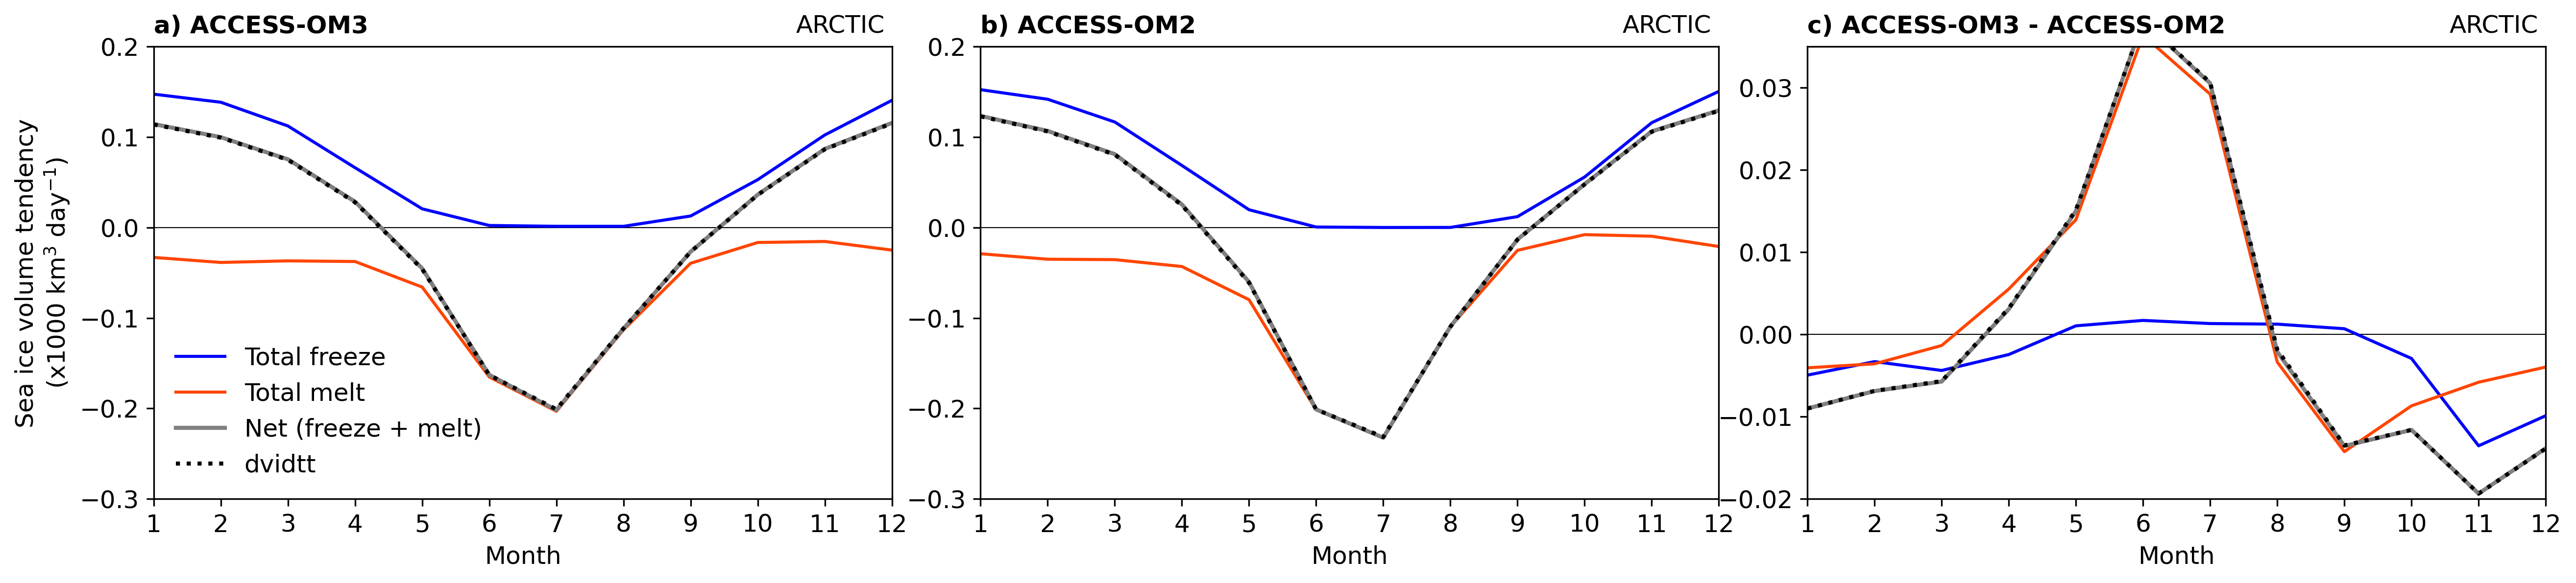

In [24]:
region = 'ARCTIC'
fig, axes = figure(region)

x = np.arange(1, 13, 1)

### OM3 ###
freeze =  arctic_seaice['frazil_m'] + arctic_seaice['congel_m'] + arctic_seaice['snoice_m']
melt = arctic_seaice['meltb_m'] + arctic_seaice['meltt_m'] + arctic_seaice['meltl_m']
axes[0].plot(x, freeze/1e12, c='blue', label='Total freeze')
axes[0].plot(x, -melt/1e12, c='orangered', label='Total melt')
axes[0].plot(x, (freeze - melt)/1e12, c='grey', lw=2, label='Net (freeze + melt)')
axes[0].plot(x, arctic_seaice['dvidtt_m']/1e12, c='k', ls=':', lw=2, label='dvidtt')

axes[0].legend(frameon=False, ncols=1, fontsize=12, loc='lower left')

### OM2 ###
freeze_om2 =  arctic_seaice_om2['frazil_m'] + arctic_seaice_om2['congel_m'] + arctic_seaice_om2['snoice_m']
melt_om2 = arctic_seaice_om2['meltb_m'] + arctic_seaice_om2['meltt_m'] + arctic_seaice_om2['meltl_m']
axes[1].plot(x, freeze_om2/1e12, c='blue', label='Total freeze')
# axes[0].plot(x, freeze_om2/1e12, c='cyan', label='Total freeze')
axes[1].plot(x, -melt_om2/1e12, c='orangered', label='Total melt')
# axes[0].plot(x, -melt_om2/1e12, c='firebrick', label='Total melt')
axes[1].plot(x, (freeze_om2 - melt_om2)/1e12, c='grey', lw=2, label='Net (freeze + melt)')
axes[1].plot(x, arctic_seaice_om2['dvidtt_m']/1e12, c='k', ls=':', lw=2, label='dvidtt')

### Difference (OM3 - OM2) ###
axes[2].plot(x, (freeze - freeze_om2)/1e12, c='blue', label='Total freeze')
axes[2].plot(x, (-melt - -melt_om2)/1e12, c='orangered', label='Total melt')
axes[2].plot(x, ((freeze - melt) - (freeze_om2 - melt_om2))/1e12, c='grey', lw=2, label='Net (freeze + melt)')
axes[2].plot(x, (arctic_seaice['dvidtt_m'] - arctic_seaice_om2['dvidtt_m'])/1e12, c='k', ls=':', lw=2, label='dvidtt')

axes[0].set_ylim([-0.3, 0.2])
axes[1].set_ylim([-0.3, 0.2])
axes[2].set_ylim([-0.02, 0.035])

figfile = plotfolder + f'seaice_vol_budget_{region}.jpg'
plt.savefig(figfile, dpi=300, bbox_inches='tight') 

plt.show()

### Check `freeze` - `melt` and `dvidtt` residuals

In [25]:
def figure():
    plt.rcParams['font.size'] = 12
    fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.08)

    axes[0].text(0.0, 1.03, 'a) ACCESS-OM3', fontsize=12, fontweight='bold', transform=axes[0].transAxes)
    axes[1].text(0.0, 1.03, 'b) ACCESS-OM2', fontsize=12, fontweight='bold', transform=axes[1].transAxes)

    for i, ax in enumerate(axes):
        ax.plot(np.arange(1,13,1), np.full(12,0), lw=0.5, c='k')
        ax.set_xlim([1,12])
        ax.set_xticks(np.arange(1,13,1))
        ax.set_xlabel('Month')
    
    axes[0].set_ylabel('Sea ice volume tendency\n(x1000 km$^3$ day$^{-1}$)')
        
    return fig, axes

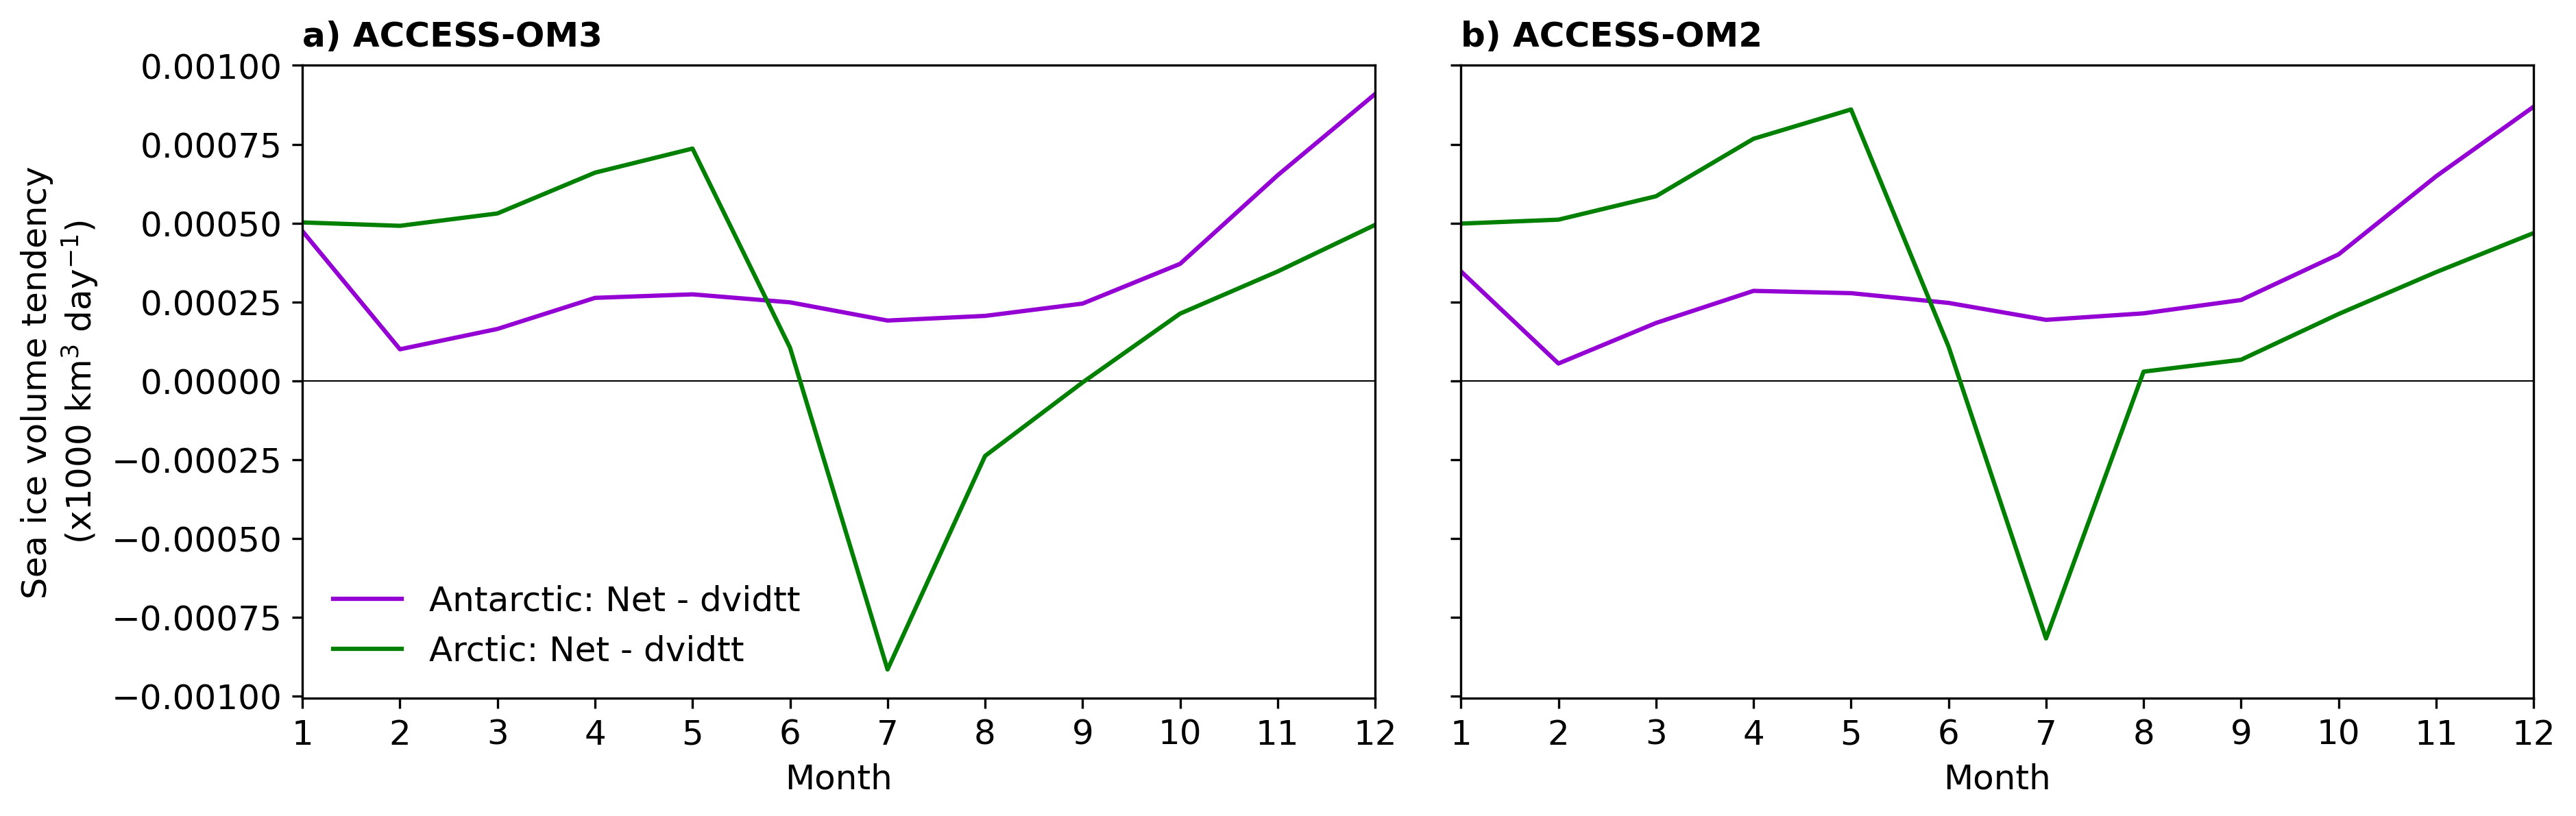

In [26]:
fig, axes = figure()

x = np.arange(1, 13, 1)

freeze =  antarctic_seaice['frazil_m'] + antarctic_seaice['congel_m'] + antarctic_seaice['snoice_m']
melt = antarctic_seaice['meltb_m'] + antarctic_seaice['meltt_m'] + antarctic_seaice['meltl_m']
freeze_om2 =  antarctic_seaice_om2['frazil_m'] + antarctic_seaice_om2['congel_m'] + antarctic_seaice_om2['snoice_m']
melt_om2 = antarctic_seaice_om2['meltb_m'] + antarctic_seaice_om2['meltt_m'] + antarctic_seaice_om2['meltl_m']
axes[0].plot(x, ((freeze - melt) - antarctic_seaice['dvidtt_m'])/1e12, c='darkviolet', label='Antarctic: Net - dvidtt')
axes[1].plot(x, ((freeze_om2 - melt_om2) - antarctic_seaice_om2['dvidtt_m'])/1e12, c='darkviolet', label='Antarctic: Net - dvidtt')


freeze =  arctic_seaice['frazil_m'] + arctic_seaice['congel_m'] + arctic_seaice['snoice_m']
melt = arctic_seaice['meltb_m'] + arctic_seaice['meltt_m'] + arctic_seaice['meltl_m']
freeze_om2 =  arctic_seaice_om2['frazil_m'] + arctic_seaice_om2['congel_m'] + arctic_seaice_om2['snoice_m']
melt_om2 = arctic_seaice_om2['meltb_m'] + arctic_seaice_om2['meltt_m'] + arctic_seaice_om2['meltl_m']
axes[0].plot(x, ((freeze - melt) - arctic_seaice['dvidtt_m'])/1e12, c='green', label='Arctic: Net - dvidtt')
axes[1].plot(x, ((freeze_om2 - melt_om2) - arctic_seaice_om2['dvidtt_m'])/1e12, c='green', label='Arctic: Net - dvidtt')

axes[0].legend(frameon=False, ncols=1, fontsize=12, loc='lower left')

figfile = plotfolder + f'seaice_vol_budget_net-dvidtt_differences.jpg'
plt.savefig(figfile, dpi=300, bbox_inches='tight') 

plt.show()

In [27]:
client.close()